In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/saved-vit-model/vit_large_patch16_384_1_64_0.0001_0.6564.pth
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_adjectives.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_trendings.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_nouns.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_flavors.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_verbs.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_movements.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_mediums.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_artists.pkl
/kaggle/input/clip-interrogator-models-x/ViT-H-14_laion2b_s32b_b79k_negative.pkl
/kaggle/input/clip-interrogator-models-x/model_large_caption.pth
/kaggle/input/clip-interrogator-models-x/CLIP-ViT-H-14-laion2B-s32B-b79K/config.json
/kaggle/input/clip-interrogator-models-x/CLIP-ViT-H

# 0. Module installation
### ref to https://www.kaggle.com/code/leonidkulyk/lb-0-45836-blip-clip-clip-interrogator

In [2]:
#!pip install --no-index /kaggle/input/transformer-4180/transformers_4.18.0/sacremoses-0.0.53-py3-none-any.whl
#!pip install --no-index -q /kaggle/input/transformer-4180/transformers_4.18.0/transformers-4.18.0.dev0-py3-none-any.whl
# Using the pre compiled wheel since we don't have internet on submission
!pip install -q /kaggle/input/stable-diffusion-data/transformers-4.18.0.dev0-py3-none-any.whl

from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator

In [3]:
import os
import sys
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate

from torchvision import transforms
from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd
import torch

!pip install --no-index --find-links /kaggle/input/clip-interrogator-wheels-x /kaggle/input/clip-interrogator-wheels-x/clip_interrogator-0.4.3-py3-none-any.whl -q
import inspect
import importlib

from blip.models import blip
import open_clip
from clip_interrogator import clip_interrogator

sys.path.append('/kaggle/input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models, util

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.8.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*

In [4]:
# fix clip_interrogator bug
clip_interrogator_path = inspect.getfile(clip_interrogator.Interrogator)

fin = open(clip_interrogator_path, "rt")
data = fin.read()
data = data.replace(
    'open_clip.get_tokenizer(clip_model_name)', 
    'open_clip.get_tokenizer(config.clip_model_name.split("/", 2)[0])'
)
fin.close()

fin = open(clip_interrogator_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(clip_interrogator)

<module 'clip_interrogator.clip_interrogator' from '/opt/conda/lib/python3.7/site-packages/clip_interrogator/clip_interrogator.py'>

# 1. Build models
### standard model
### Chose all-MiniLM-L6-v2
### This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

## 1.0 Preparation

In [5]:
#model = SentenceTransformer('all-MiniLM-L6-v2')
st_model = SentenceTransformer("/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2")

### Prepare functions of encode, scoring, plotting

In [6]:
import matplotlib.image as mpimg
import textwrap

def Prompt2Emb(input_li):
    if isinstance(input_li,str):
        input_li = [input_li]
    out_li = []
    for element in input_li:
        if type(element) is str:
            out = st_model.encode(element, show_progress_bar=False)
        else:
            out = element
        if isinstance(out, torch.Tensor):
            out = out.detach().cpu().numpy()
        out_li.append(out)
    output_li = out_li[0] if isinstance(input_li,str) else out_li
    return output_li

def scoring(prompt_li, prompt_clip_li):
    score_li=[]
    prompt_emb_li = Prompt2Emb(prompt_li)
    pre_prompt_emb_li = Prompt2Emb(prompt_clip_li)
    for prompt_emb, predict_emb in zip(prompt_emb_li, pre_prompt_emb_li):
        cosine_similarity_score = util.cos_sim(prompt_emb.astype(float), predict_emb.astype(float)).numpy().flatten()
        score_li.append(cosine_similarity_score[0])
    return score_li

def image_grid(imgs, prompts='', prompts2='', score_li='', rows=1, cols=7):
    assert len(imgs) == rows*cols
    Figure=plt.figure(figsize=(18,15))
    for idx,img in enumerate(imgs):
        ax=Figure.add_subplot(cols,rows,idx+1)
        ax.imshow(img)
        ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
        if score_li!='':
            ax.annotate('score: %.3f'%(score_li[idx]),xycoords='axes fraction',ha='left',va='top',xy=(1.1,1.0),wrap=True,fontsize=12,c='r')
        if prompts!='':
            prompt = prompts[idx]
            text= '\n'.join(textwrap.wrap(prompt,60))
            ax.annotate(text,xycoords='axes fraction',ha='left',va='top',xy=(1.1,0.9),wrap=True,fontsize=12,c='k')
        if prompts2!='':
            prompt2 = prompts2[idx]
            text2= '\n'.join(textwrap.wrap(prompt2,60))
            ax.annotate(text2,xycoords='axes fraction',ha='left',va='top',xy=(1.1,0.3),wrap=True,fontsize=12,c='b')
    plt.show()

## 1.1 CLIP interrogator model

### 1.1.1 build model

In [7]:
class CFG:
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
#    seed = 42
    embedding_length = 384
#    sentence_model_path = "/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2"
    blip_model_path = "/kaggle/input/clip-interrogator-models-x/model_large_caption.pth"
    ci_clip_model_name = "ViT-H-14/laion2b_s32b_b79k"
    clip_model_name = "ViT-H-14"
    clip_model_path = "/kaggle/input/clip-interrogator-models-x/CLIP-ViT-H-14-laion2B-s32B-b79K/open_clip_pytorch_model.bin"
    cache_path = "/kaggle/input/clip-interrogator-models-x"

### CLIP Interrogator uses OpenCLIP which supports many different pretrained CLIP models.
### For the best prompts for Stable Diffusion 1.X use ViT-L-14/openai for clip_model_name.
### For Stable Diffusion 2.0 use ViT-H-14/laion2b_s32b_b79k

In [8]:
# replace tokenizer path to prevent downloading
blip_path = inspect.getfile(blip)

fin = open(blip_path, "rt")
data = fin.read()
data = data.replace(
    "BertTokenizer.from_pretrained('bert-base-uncased')", 
    "BertTokenizer.from_pretrained('/kaggle/input/clip-interrogator-models-x/bert-base-uncased')"
)
fin.close()

fin = open(blip_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(blip)
del data

### This part I haven't really understand it

In [9]:
model_config = clip_interrogator.Config(clip_model_name = CFG.ci_clip_model_name)
model_config.cache_path = CFG.cache_path

#blip_path = "/opt/conda/lib/python3.7/site-packages/blip/models/blip.py"
configs_path = os.path.join(os.path.dirname(os.path.dirname(blip_path)), 'configs')
med_config = os.path.join(configs_path, 'med_config.json')
blip_model = blip.blip_decoder(
    pretrained=CFG.blip_model_path,
    image_size=model_config.blip_image_eval_size, 
    vit=model_config.blip_model_type, 
    med_config=med_config
)

blip_model.eval()
blip_model = blip_model.to(model_config.device)
model_config.blip_model = blip_model


load checkpoint from /kaggle/input/clip-interrogator-models-x/model_large_caption.pth


In [10]:
clip_model = open_clip.create_model(CFG.clip_model_name, precision='fp16' if model_config.device == 'cuda' else 'fp32')
open_clip.load_checkpoint(clip_model, CFG.clip_model_path)
clip_model.to(model_config.device).eval()
model_config.clip_model = clip_model

clip_preprocess = open_clip.image_transform(
    clip_model.visual.image_size,
    is_train = False,
    mean = getattr(clip_model.visual, 'image_mean', None),
    std = getattr(clip_model.visual, 'image_std', None),
)

model_config.clip_preprocess = clip_preprocess

ci = clip_interrogator.Interrogator(model_config)

Loaded CLIP model and data in 1.98 seconds.


In [11]:
# create the inverse transform
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    transforms.ToPILImage()
])

cos = torch.nn.CosineSimilarity(dim=1)

mediums_features_array = torch.stack([torch.from_numpy(t) for t in ci.mediums.embeds]).to(ci.device)
movements_features_array = torch.stack([torch.from_numpy(t) for t in ci.movements.embeds]).to(ci.device)
flavors_features_array = torch.stack([torch.from_numpy(t) for t in ci.flavors.embeds]).to(ci.device)

class MyClip:
    def __init__(self, model = ci, withFlave = True):
        self.model = model
        self.withFlave = withFlave
    def img_list(self, img_list):
        if len(img_list) == 1 and not isinstance(img_list, list) and not isinstance(img_list, torch.Tensor):
            img_list = [img_list]
        if isinstance(img_list[0], torch.Tensor):
            img_list = [inverse_transform(img) for img in img_list]
        else:
            pass
        return img_list
    def predict_prompt(self, img_list):
        img_list = self.img_list(img_list)
        prompts = []
        for img in img_list:
            prompt = self.model.generate_caption(img)
            if self.withFlave:
                medium, movement, flaves = self.feature(img)
                if prompt.startswith(medium):
                    prompt = f"{prompt}, {movement}, {flaves}"
                else:
                    prompt = f"{prompt}, {medium}, {movement}, {flaves}"
                prompt = clip_interrogator._truncate_to_fit(prompt, self.model.tokenize)
            prompts.append(prompt)
        return prompts[0] if len(prompts)==1 else prompts
    def feature(self, img):
        image_features = self.model.image_to_features(img)
        medium = [self.model.mediums.labels[i] for i in cos(image_features, mediums_features_array).topk(1).indices][0]
        movement = [self.model.movements.labels[i] for i in cos(image_features, movements_features_array).topk(1).indices][0]
        flaves = ", ".join([self.model.flavors.labels[i] for i in cos(image_features, flavors_features_array).topk(3).indices])
        return medium, movement, flaves
    
    def predict_emb(self, img_list):
        prompts = self.predict_prompt(img_list)
        embeddings = Prompt2Emb(prompts)
        return embeddings[0] if len(embeddings)==1 else embeddings

my_clip = MyClip()

### 1.1.2 Test sample images
### check scores and imaging for sample

## 1.2 ViT-B-16 Model

### 1.2.1 Build model¶

In [12]:
class ViT_CFG:
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model_path = '/kaggle/input/saved-vit-model/vit_large_patch16_384_1_64_0.0001_0.6564.pth'
    model_name = 'vit_large_patch16_384'
    input_size = (384, 384)
    batch_size = 64

In [13]:
import timm

vit_model = timm.create_model(
    model_name = ViT_CFG.model_name,
    pretrained = False,
    num_classes = 384
)
state_dict = torch.load(ViT_CFG.model_path)
vit_model.load_state_dict(state_dict)
vit_model.to(ViT_CFG.device)
vit_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  

In [14]:
import torch.nn.functional as F
class MyViT:
    def __init__(self, model = vit_model, tta=2):
        self.model = model
        self.tta = tta
        self.transformPIL = transforms.Compose([
                        transforms.Resize(ViT_CFG.input_size),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        ])
        
    def img_list(self, img_list): # The output img_list need to be torch.tensor
        if isinstance(img_list, torch.Tensor):
            if img_list.dim() == 3:
                img_list = img_list.unsqueeze(0)
            img_list = F.interpolate(img_list, size=ViT_CFG.input_size, mode='bilinear', align_corners=False).to(ViT_CFG.device)
        else:
            if isinstance(img_list, Image.Image):
                img_list = [img_list]
            img_list = [self.transformPIL(img).to(ViT_CFG.device) for img in img_list]
        return img_list
    def predict_emb(self, img_list):
        img_list = self.img_list(img_list)
        embeddings = []
        for img_emb in img_list:
            to_stack = np.empty((0, CFG.embedding_length))
            for t in np.arange(self.tta):
                embedding = self.model(img_emb.unsqueeze(0)).squeeze(0).detach().cpu().numpy()
                #embedding = embedding/(abs(embedding).max()+0.0000001)
                to_stack = np.vstack((to_stack,embedding))
            embedding = np.average(to_stack, axis=0)
            embedding = embedding / np.linalg.norm(embedding)
            embeddings.append(embedding)
        return embeddings
my_vit = MyViT()

### 1.2.2 Test sample images

## 1.3 OFA model

### https://www.kaggle.com/code/parikshitsharma2001/lb-0-55161-clipinterrogator-ofa-vit

### 1.3.1 Build Model

In [15]:
class OFA_CFG:
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    #model_path = '/kaggle/input/stable-diffusion-vit-baseline-train/vit_base_patch16_224.pth'
    #model_path = '/kaggle/input/vit-large/vit_large_patch16_224.pth'
    #model_name = 'vit_large_patch16_224'
    #model_path = '/kaggle/input/timm-vit-huge-patch14-224-in21k/pytorch_model.bin'
    #model_name = 'vit_huge_patch14_224_in21k'
    #input_size = (224, 224)
    #batch_size = 64

In [16]:
CKPT_DIR = "/kaggle/input/stable-diffusion-data/OFA-large-caption/"

ofa_tokenizer = OFATokenizer.from_pretrained(CKPT_DIR)
ofa_model = OFAModel.from_pretrained(CKPT_DIR, use_cache=False).cuda()
txt = " what does the image describe?"
ask_inputs = ofa_tokenizer([txt], return_tensors="pt").input_ids

/kaggle/input/stable-diffusion-data/OFA-large-caption/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [17]:
mean, std = [1, 1, 1], [1, 1, 1]
#mean, std = [0.0, 0.0, 0.0], [1.0, 1.0, 1.0]
resolution = 512 # I change from 480 (default) to the original resolution, or we just remove resize
ofa_transform = transforms.Compose([
        lambda image: image.convert("RGB"),
        #transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
        transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std)
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [18]:
class MyOFA:
    def __init__(self, model = ofa_model):
        self.model = model
    def img_list(self, img_list):
        if len(img_list) == 1 and not isinstance(img_list, list) and not isinstance(img_list, torch.Tensor):
            img_list = [img_list]
        if isinstance(img_list[0], Image.Image):
            img_list = [ofa_transform(img).unsqueeze(0).to(OFA_CFG.device) for img in img_list]
        elif isinstance(img_list[0], torch.Tensor):
            img_list = [img.unsqueeze(0) for img in img_list]
        else:
            pass
        return img_list
        
    def predict_prompt(self, img_list):
        img_list = self.img_list(img_list)
        prompts = []
        for img in img_list:
            emb_ofa = self.model.generate(ask_inputs.cuda(), patch_images=img, num_beams=5, no_repeat_ngram_size=2)
            prompt = ofa_tokenizer.batch_decode(emb_ofa, skip_special_tokens=True)[0]
            prompts.append(prompt)
        return prompts[0] if len(prompts)==1 else prompts

    def predict_emb(self, img_list):
        prompts = self.predict_prompt(img_list)
        embeddings = Prompt2Emb(prompts)
        embeddings = embeddings / np.linalg.norm(embeddings)
        return embeddings[0] if len(embeddings)==1 else embeddings

my_ofa = MyOFA()

# 3. Online Data (need internet)

### ref to https://www.kaggle.com/code/debarshichanda/pytorch-blip-training/notebook

## 3.1 download dataset

In [19]:
from datasets import load_dataset
# Load the dataset with the `2m_random_1k` subset, see the link
dataset = load_dataset('poloclub/diffusiondb', '2m_random_1k', split='train')

#dataset = dataset['train']

Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusion_db downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusion_db/2m_random_1k/0.9.1/b3bc1e64570dc7149af62c4bac49ecfbce16b683dd4fee083292fae1afa95f7c. Subsequent calls will reuse this data.


### https://github.com/poloclub/diffusiondb/blob/main/notebooks/example-loading.ipynb

In [20]:
new_dataset = {'image':[],'prompt':[]}
j = 0
for i in tqdm(range(len(dataset))):
    image = dataset[i]['image']
    prompt = dataset[i]['prompt']
    if image.size == (512,512):
        j+=1
        new_dataset['image'].append(image)
        new_dataset['prompt'].append(prompt)
    del image
    del prompt
dataset = pd.DataFrame.from_dict(new_dataset)
del new_dataset

100%|██████████| 1000/1000 [00:27<00:00, 35.91it/s]


In [21]:
from IPython.display import display
#display(dataset)

### check data randomly

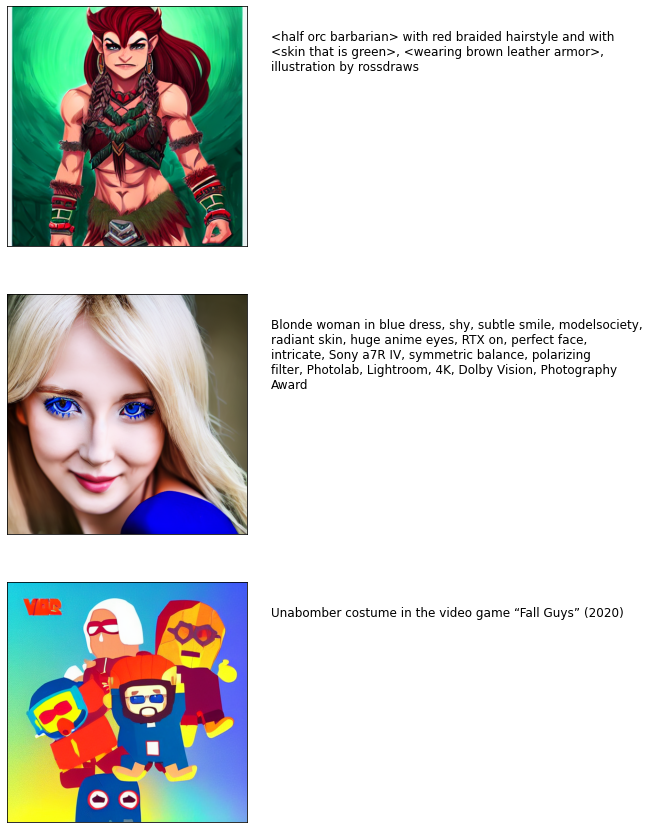

In [22]:
size = 3
imgs = []
prompts = []
for idx in np.random.randint(low=0, high=len(dataset['prompt']), size=size):
    imgs.append(dataset['image'][idx])
    prompts.append(dataset['prompt'][idx])
image_grid(imgs, prompts=prompts, prompts2='', score_li='', rows=1, cols=size)

# 4. Ensembling Model

## 4.1 Ensembling

In [23]:
from torch import nn, optim

Init = torch.tensor([[0.52], [0.3], [0.18]]).repeat(1, 384)

class Ensemble_Model(nn.Module):
    def __init__(self, model_li):
        super().__init__()
        self.model1 = model_li[0]
        self.model2 = model_li[1]
        self.model3 = model_li[2]
        #        self.weights = torch.nn.Parameter(torch.tensor([0.52, 0.3, 0.18],dtype=torch.float32, requires_grad=True))
        self.weights = torch.nn.Parameter(torch.tensor(Init, dtype=torch.float32, requires_grad=True))
#        # Set weights to sum up to 1
    def forward(self, x):
        self.weights /= self.weights.sum(dim=0)
        # Calculate the embeddings for each model and compute the weighted sum
        embeddings = torch.zeros((x.size(0), self.model1.embedding_size))
        for i, model in enumerate([self.model1, self.model2, self.model3]):
            model_embedding = model.predict_emb(x)
            embeddings += model_embedding * self.weights[i]
#        embeddings /= torch.sum(self.weights)
        return embeddings

    def predict(self, X):
        embedding1 = self.model1.predict_emb(X)
        embedding2 = self.model2.predict_emb(X)
        embedding3 = self.model3.predict_emb(X)
        embeddings = torch.tensor(embedding1) * self.weights[0]
        + torch.tensor(embedding2) * self.weights[1]
        + torch.tensor(embedding3) * self.weights[2]
        return embeddings
    
    def parameters(self):
        return [self.weights]

## 4.2 training

In [24]:
# 定義圖像資料集類別
class PromptImageDataset(Dataset):
    def __init__(self, prompt_list, image_list):
        self.image_list = image_list
        self.prompt_list = prompt_list
        
        self.transform = transforms.Compose([
            #transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        # 讀取圖像並將其轉換為 RGB 格式
        image = self.image_list[index]
        image = image.convert("RGB")
        image = self.transform(image).to(CFG.device)
        
        prompt = self.prompt_list[index]
        embedding = Prompt2Emb(prompt)
        embedding = torch.Tensor(embedding).to(CFG.device)
        
        return embedding, image

In [25]:
from sklearn.model_selection import train_test_split
# 將數據集分割為訓練集和驗證集，比例為9:1
train_data, val_data = train_test_split(dataset, test_size=100, random_state=42)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
# 創建訓練集和驗證集的資料集對象
train_dataset = PromptImageDataset(train_data['prompt'], train_data['image'])
val_dataset = PromptImageDataset(val_data['prompt'], val_data['image'])

In [26]:
batch_size = 24
train_loader = DataLoader(dataset=train_dataset,  # 使用上面創建的圖像資料集對象
                        batch_size=batch_size,  # 每批次讀取的圖像數量
                        num_workers=0,  # 用於讀取數據的工作進程數
                        shuffle=True)  # 是否打亂資料集順序，此處打亂

val_loader = DataLoader(dataset=val_dataset,  # 使用上面創建的圖像資料集對象
                        batch_size=batch_size,  # 每批次讀取的圖像數量
                        num_workers=0,  # 用於讀取數據的工作進程數
                        shuffle=False)  # 是否打亂資料集順序，此處不打亂

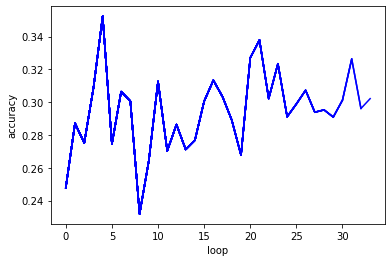


100%|██████████| 2/2 [6:58:24<00:00, 12552.37s/it]


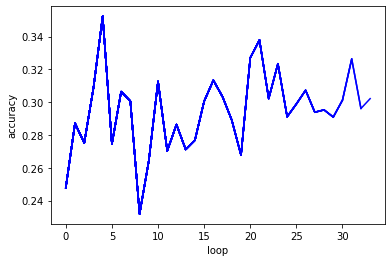

In [27]:
import torch.nn.functional as F
from IPython import display

my_model = Ensemble_Model([my_vit, my_clip, my_ofa])
data_path = '/kaggle/input/ensembleweight-hsieh/'
if os.path.exists(data_path+'ensemble_model_weights.pth'):
    my_model.load_state_dict(torch.load(data_path+'ensemble_model_weights.pth'))
    accuracy_li = np.loadtxt(data_path+'/accuracy.txt')
    print('Using from last training point')
else:
    accuracy_li = np.array([])

# Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.CosineEmbeddingLoss()
#optimizer = optim.SGD(my_model.parameters(), lr=0.01)
optimizer = optim.Adam(my_model.parameters(), lr=0.1)

num_epochs = 2

test_acc = []
fig, ax = plt.subplots()
ax.set_xlabel('loop')
ax.set_ylabel('accuracy')
# Loop over the training dataset

import time
time_begin = time.time()
time_note = time.time()

break_outer_loop = False
for epoch in tqdm(range(num_epochs), total=num_epochs):
    for bat, (labels, inputs) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
#        if bat > 1:continue    

        my_model.train()
        labels = labels[0].to(CFG.device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        inputs.requires_grad = True
        outputs = my_model.predict(inputs)
        outputs.detach().requires_grad = True
        outputs = outputs.to(CFG.device)

        # Compute the loss
        cos_sim = F.cosine_similarity(outputs, labels, dim=1)  # Compute cosine similarity
        target = cos_sim#.mean().unsqueeze(0)  # Compute mean and reshape to match expected shape
        loss = criterion(outputs, labels, 1 - target)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Normalize weights
        with torch.no_grad():
            my_model.weights.data = my_model.weights.data / my_model.weights.data.sum()

        # Evaluate the model on the validation set after each epoch
        my_model.eval()
        cos_sim_test = []
        #for xxx, (labels, inputs) in enumerate(val_loader):
        for xxx, (labels, inputs) in enumerate(train_loader):
            labels = labels[0].to('cpu')
            outputs = my_model.predict(inputs.to(CFG.device))
            cos_sim_test.extend(F.cosine_similarity(outputs, labels, dim=1))
        accuracy = np.average(torch.Tensor(cos_sim_test).detach().numpy())
        print(accuracy)
        accuracy_li = np.append(accuracy_li, accuracy)
        ax.plot(np.arange(len(accuracy_li)), accuracy_li, 'b-')

        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        if time.time() > time_note + 1*60*60:
            torch.save(my_model.state_dict(), 'ensemble_model_weights.pth')
            np.savetxt('accuracy.txt', accuracy_li)
            time_note = time.time()
        if time.time() > time_begin + 10*60*60:
            torch.save(my_model.state_dict(), 'ensemble_model_weights.pth')
            np.savetxt('accuracy.txt', accuracy_li)
            break_outer_loop = True
            break
    if break_outer_loop:
        break